**Siamese Network One-Shot**

In [52]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import  numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns

In [39]:
full_df = pd.read_csv('consolidated_SERS.csv')
full_df['Class'] = full_df['Label'].astype(str) + '__' + full_df['Substrate'].astype(str)

In [40]:
# 3) Split 20% train / 80% query per class
train_Df,query_df = train_test_split(full_df,test_size=0.8, stratify=full_df['Class'], random_state=42)
train_df = train_df.reset_index(drop=True)
query_df = query_df.reset_index(drop=True)

In [41]:
# 4) Load averaged SERS per label-substrate as reference for Siamese
ref_avg = pd.read_csv('consolidated_SERS_avg.csv')
ref_avg['Class'] = ref_avg['Label'].astype(str) + '__' + ref_avg['Substrate'].astype(str)
# 5) Identify spectral columns
spectral_cols = [c for c in ref_avg.columns if c not in ['Label','Substrate','Class']]

# 6) Extract reference and query arrays and labels
ref_specs = ref_avg[spectral_cols].values.astype(float)
ref_labels = ref_avg['Class'].values

qry_specs = query_df[spectral_cols].values.astype(float)
qry_labels = query_df['Class'].values

In [42]:
lam, p, niter = 1e4, 0.01, 10
def baseline_als(y):
    L = len(y)
    D = np.diff(np.eye(L), 2)
    D = lam * D.dot(D.T)
    w = np.ones(L)
    for _ in range(niter):
        b = np.linalg.solve(np.diag(w) + D, w * y)
        w = p * (y > b) + (1 - p) * (y < b)
    return b

def preprocess(arr):
    out = np.zeros_like(arr)
    for i, s in enumerate(arr):
        b = baseline_als(s)
        c = s - b
        norm = np.linalg.norm(c)
        out[i] = c / norm if norm > 0 else c
    return out

In [43]:
# Training data
train_specs = train_df[spectral_cols].values.astype(float)
train_labels = train_df['Class'].values
train_proc = preprocess(train_specs)

In [44]:
# Query data
qry_specs = query_df[spectral_cols].values.astype(float)
qry_labels = query_df['Class'].values
qry_proc = preprocess(qry_specs)

# Reference data (averages)
ref_specs = ref_avg[spectral_cols].values.astype(float)
ref_labels = ref_avg['Class'].values
ref_proc = preprocess(ref_specs)

In [45]:
np.unique(qry_labels)

array(['4np__AgNP', '4np__PICO', '4np__pSERS', 'benzenethiol__Ag',
       'benzenethiol__Au', 'bt__PICO', 'bt__pSERS',
       'n,n-dimethylformamide__AuNP', 'pyridine__AgNP', 'pyridine__AuNP',
       'pyridine__PICO', 'pyridine__pSERS'], dtype=object)

In [46]:
def augment(spec, noise_std=0.01, shift_max=2):
    spec_noisy = spec + np.random.normal(0, noise_std, size=spec.shape)
    shift = np.random.randint(-shift_max, shift_max + 1)
    return np.roll(spec_noisy, shift)

# 3. Pair dataset for contrastive learning
class RamanPairDataset(Dataset):
    def __init__(self, specs, labels, augment_fn=None):
        self.specs = specs
        self.labels = labels
        self.augment = augment_fn
        self.by_label = {c: np.where(labels == c)[0] for c in np.unique(labels)}

    def __len__(self):
        return len(self.specs)

    def __getitem__(self, idx):
        x1 = self.specs[idx]
        y1 = self.labels[idx]
        if np.random.rand() < 0.5:
            j = np.random.choice(self.by_label[y1])
            label = 1.0
        else:
            neg = [c for c in self.by_label if c != y1]
            y2 = np.random.choice(neg)
            j = np.random.choice(self.by_label[y2])
            label = 0.0
        x2 = self.specs[j]
        if self.augment:
            x1 = self.augment(x1)
            x2 = self.augment(x2)
        return (torch.tensor(x1, dtype=torch.float32).unsqueeze(0),
                torch.tensor(x2, dtype=torch.float32).unsqueeze(0),
                torch.tensor(label, dtype=torch.float32))

# 4. Siamese network definition
class SiameseNet(nn.Module):
    def __init__(self, input_len, embed_dim=64):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=7, padding=3), nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(16, 32, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Flatten(),
            nn.Linear((input_len // 4) * 32, embed_dim),
            nn.ReLU()
        )

    def forward(self, x):
        z = self.encoder(x)
        return F.normalize(z, dim=1)

# 5. Contrastive loss
def contrastive_loss(z1, z2, label, margin=1.0):
    dist = F.pairwise_distance(z1, z2)
    loss_pos = label * dist**2
    loss_neg = (1 - label) * F.relu(margin - dist)**2
    return (loss_pos + loss_neg).mean()

In [47]:
# 8) Prepare DataLoader, model, optimizer
input_len = train_proc.shape[1]
dataset = RamanPairDataset(train_proc, train_labels, augment_fn=augment)
loader = DataLoader(dataset, batch_size=32, shuffle=True)
model = SiameseNet(input_len, embed_dim=64)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 9) Train Siamese network
model.train()
for epoch in range(1, 101):
    total_loss = 0.0
    for x1, x2, lbl in loader:
        z1, z2 = model(x1), model(x2)
        loss = contrastive_loss(z1, z2, lbl)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x1.size(0)
    avg_loss = total_loss / len(dataset)
    print(f"Epoch {epoch}, Loss: {avg_loss:.4f}")



Epoch 1, Loss: 0.4753
Epoch 2, Loss: 0.4905
Epoch 3, Loss: 0.4158
Epoch 4, Loss: 0.4554
Epoch 5, Loss: 0.4356
Epoch 6, Loss: 0.4950
Epoch 7, Loss: 0.4006
Epoch 8, Loss: 0.3167
Epoch 9, Loss: 0.3762
Epoch 10, Loss: 0.5187
Epoch 11, Loss: 0.4725
Epoch 12, Loss: 0.4850
Epoch 13, Loss: 0.4094
Epoch 14, Loss: 0.3185
Epoch 15, Loss: 0.1152
Epoch 16, Loss: 0.1422
Epoch 17, Loss: 0.1021
Epoch 18, Loss: 0.0747
Epoch 19, Loss: 0.0593
Epoch 20, Loss: 0.0596
Epoch 21, Loss: 0.0427
Epoch 22, Loss: 0.0315
Epoch 23, Loss: 0.0301
Epoch 24, Loss: 0.0362
Epoch 25, Loss: 0.0362
Epoch 26, Loss: 0.0186
Epoch 27, Loss: 0.0453
Epoch 28, Loss: 0.0362
Epoch 29, Loss: 0.0393
Epoch 30, Loss: 0.0149
Epoch 31, Loss: 0.0162
Epoch 32, Loss: 0.0295
Epoch 33, Loss: 0.0260
Epoch 34, Loss: 0.0105
Epoch 35, Loss: 0.0265
Epoch 36, Loss: 0.0372
Epoch 37, Loss: 0.0192
Epoch 38, Loss: 0.0487
Epoch 39, Loss: 0.0158
Epoch 40, Loss: 0.0249
Epoch 41, Loss: 0.0224
Epoch 42, Loss: 0.0204
Epoch 43, Loss: 0.0237
Epoch 44, Loss: 0.01

In [48]:
# 10) Compute embeddings for reference and query
model.eval()
with torch.no_grad():
    ref_embeds = model(torch.tensor(ref_proc, dtype=torch.float32).unsqueeze(1)).cpu().numpy()
    qry_embeds = model(torch.tensor(qry_proc, dtype=torch.float32).unsqueeze(1)).cpu().numpy()

# 11) 1‑NN classification of query against averaged references
pred_labels = []
for q in qry_embeds:
    idx = np.argmin(np.linalg.norm(ref_embeds - q, axis=1))
    pred_labels.append(ref_labels[idx])

In [49]:
ref_labels

array(['4np__AgNP', '4np__PICO', '4np__pSERS', 'benzenethiol__Ag',
       'benzenethiol__Au', 'bt__PICO', 'bt__pSERS',
       'n,n-dimethylformamide__AuNP', 'pyridine__AgNP', 'pyridine__AuNP',
       'pyridine__PICO', 'pyridine__pSERS'], dtype=object)

In [50]:
np.unique(qry_labels)

array(['4np__AgNP', '4np__PICO', '4np__pSERS', 'benzenethiol__Ag',
       'benzenethiol__Au', 'bt__PICO', 'bt__pSERS',
       'n,n-dimethylformamide__AuNP', 'pyridine__AgNP', 'pyridine__AuNP',
       'pyridine__PICO', 'pyridine__pSERS'], dtype=object)

Top‑1 Accuracy: 95.29%

Classification Report:
                             precision    recall  f1-score   support

                  4np__AgNP       0.80      0.20      0.32        20
                  4np__PICO       1.00      1.00      1.00        20
                 4np__pSERS       1.00      1.00      1.00        20
           benzenethiol__Ag       0.69      1.00      0.82        20
           benzenethiol__Au       0.95      1.00      0.98        20
                   bt__PICO       1.00      1.00      1.00        20
                  bt__pSERS       1.00      1.00      1.00        20
n,n-dimethylformamide__AuNP       0.99      1.00      0.99       183
             pyridine__AgNP       0.75      0.90      0.82        20
             pyridine__AuNP       1.00      0.95      0.97        20
             pyridine__PICO       1.00      1.00      1.00        20
            pyridine__pSERS       1.00      1.00      1.00        20

                   accuracy                           

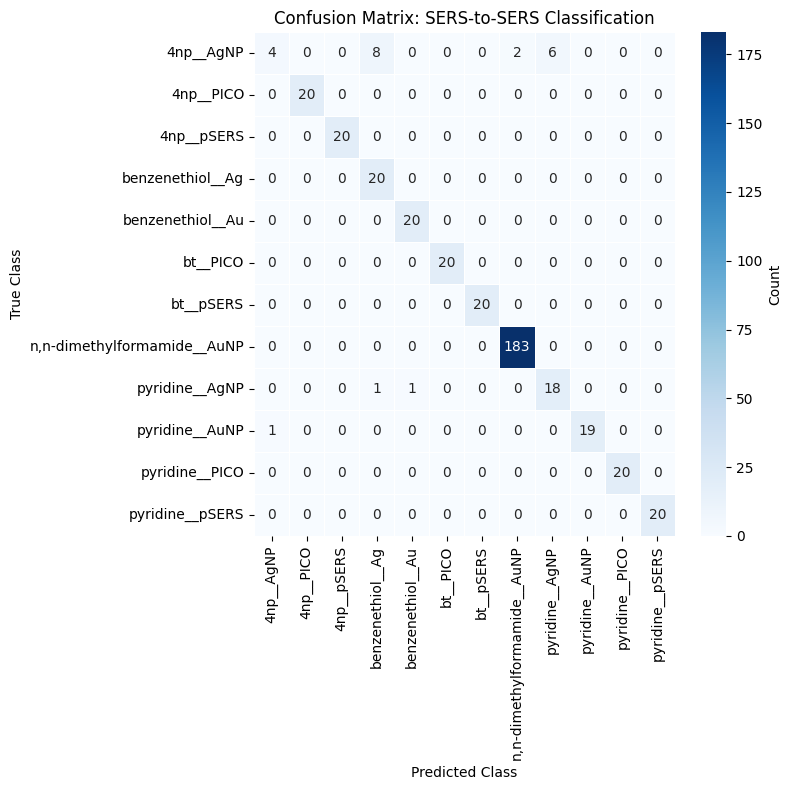

In [54]:
# 12) Evaluation
acc = accuracy_score(qry_labels, pred_labels)
print(f"Top‑1 Accuracy: {acc:.2%}\n")
print("Classification Report:")
print(classification_report(qry_labels, pred_labels, target_names=np.unique(ref_labels)))

# 13) Confusion matrix plot
classes = np.unique(ref_labels)
cm = confusion_matrix(qry_labels, pred_labels, labels=classes)
cm_df = pd.DataFrame(cm, index=classes, columns=classes)

plt.figure(figsize=(8,8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            cbar_kws={'label':'Count'}, linewidths=0.5)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix: SERS‑to‑SERS Classification')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()